In [2]:
from compute_signals import *
from process_signal_data import *


import pandas as pd
import numpy as np
from scipy.signal import welch, butter, filtfilt, hilbert

import os


#ignore warnings
import warnings
warnings.filterwarnings("ignore")

- lf is the frequency band for the Low frequency from the paper
- hf is the frequency band for the High frequency from the paper
- percent_outliers is the fraction of values to remove from the lower and upper values of the window

- We will load the the dataframe that is provided and then subsequently add the feature columns to it

In [3]:
data = pd.read_csv('userData.csv')
# data.head()

In [4]:
lf =  [0.04, 0.15]
hf = [0.15, 0.4]
percent_outliers = 0.1
plot_flag = 1
save_fig = 1
kernel_type = 'poly'
window_size =  90
offset_window = 10
sample_points = 5


- **convert_rr_total** will convert the **rr** column to arrays and save it as a column in the dataframe
- **compute_sampling_rate** will compute the sampling rate for each sample and then save it as a column

In [5]:
convert_rr_total(data)
compute_sampling_rate(data)
data.head(15)

,user,age,gender,section,duration,arousal,valence,samples,rr,rr_array,fs
0,20230608_183012_3_02001743,42,0,Rest_Start,185,3,3,215,"[783, 790, 795, 769, 768, 754, 762, 766, 774, ...","[783.0, 790.0, 795.0, 769.0, 768.0, 754.0, 762...",1.162162
1,20230608_183012_3_02001743,42,0,Reading,185,4,2,207,"[739, 749, 724, 692, 701, 724, 757, 769, 777, ...","[739.0, 749.0, 724.0, 692.0, 701.0, 724.0, 757...",1.118919
2,20230608_183012_3_02001743,42,0,Breath_1,130,5,3,155,"[750, 751, 735, 741, 749, 760, 752, 761, 774, ...","[750.0, 751.0, 735.0, 741.0, 749.0, 760.0, 752...",1.192308
3,20230608_183012_3_02001743,42,0,Stroop,190,3,0,220,"[753, 765, 778, 757, 768, 774, 775, 773, 777, ...","[753.0, 765.0, 778.0, 757.0, 768.0, 774.0, 775...",1.157895
4,20230608_183012_3_02001743,42,0,ReactionTime,227,5,3,241,"[698, 741, 791, 814, 813, 827, 849, 870, 820, ...","[698.0, 741.0, 791.0, 814.0, 813.0, 827.0, 849...",1.061674
5,20230608_183012_3_02001743,42,0,Video+,179,5,3,177,"[780, 786, 785, 775, 770, 762, 749, 762, 769, ...","[780.0, 786.0, 785.0, 775.0, 770.0, 762.0, 749...",0.988827
6,20230608_183012_3_02001743,42,0,Breath_2,131,6,4,131,"[778, 773, 767, 761, 741, 749, 747, 758, 773, ...","[778.0, 773.0, 767.0, 761.0, 741.0, 749.0, 747...",1.000000
7,20230608_183012_3_02001743,42,0,Math,190,3,2,187,"[768, 761, 738, 723, 723, 712, 727, 724, 731, ...","[768.0, 761.0, 738.0, 723.0, 723.0, 712.0, 727...",0.984211
8,20230608_183012_3_02001743,42,0,ImageStroop,294,6,4,297,"[706, 706, 700, 716, 717, 743, 741, 737, 748, ...","[706.0, 706.0, 700.0, 716.0, 717.0, 743.0, 741...",1.010204
9,20230608_183012_3_02001743,42,0,Video-,162,3,1,187,"[720, 715, 732, 723, 708, 717, 719, 728, 703, ...","[720.0, 715.0, 732.0, 723.0, 708.0, 717.0, 719...",1.154321


In [6]:
users_pass = find_users(data)
users_unique =  data.user.unique()
len(users_unique)

40

In [7]:
dict_new =  {'user':users_unique,'section':None}
df_breath1 = pd.DataFrame.from_dict(dict_new)
df_breath2 = pd.DataFrame.from_dict(dict_new)
df_breath3 = pd.DataFrame.from_dict(dict_new)
df_breath4 = pd.DataFrame.from_dict(dict_new)

df_mental = pd.DataFrame.from_dict(dict_new)
df_rest_start = pd.DataFrame.from_dict(dict_new)
df_rest_end = pd.DataFrame.from_dict(dict_new)
df_stroop = pd.DataFrame.from_dict(dict_new)
df_imagestroop = pd.DataFrame.from_dict(dict_new)
df_math = pd.DataFrame.from_dict(dict_new)
df_video_plus = pd.DataFrame.from_dict(dict_new)
df_video_minus = pd.DataFrame.from_dict(dict_new)
df_breath_total = pd.DataFrame.from_dict(dict_new)
df_rest_total  = pd.DataFrame.from_dict(dict_new)
df_reaction_time  = pd.DataFrame.from_dict(dict_new)
df_reading  = pd.DataFrame.from_dict(dict_new)

df_exercise = pd.DataFrame.from_dict(dict_new)
# a step to make empty dataframes for each user and each section


In [8]:
stroop_vals = construct_signal_general(data,users_unique,['Stroop'])
math_vals = construct_signal_general(data,users_unique,['Math'])
video_minus_vals = construct_signal_general(data,users_unique,['Video-'])
video_plus_vals = construct_signal_general(data,users_unique,['Video+'])
imagestroop_vals = construct_signal_general(data,users_unique,['ImageStroop'])
breath1_vals = construct_signal_general(data,users_unique,['Breath_1'])
breath2_vals = construct_signal_general(data,users_unique,['Breath_2'])
breath3_vals = construct_signal_general(data,users_unique,['Breath_3'])
breath4_vals = construct_signal_general(data,users_unique,['Breath_4'])
breath_total_val = construct_signal_general(data,users_unique,['Breath_1','Breath_2','Breath_3', 'Breath_4'])
rest_start_vals = construct_signal_general(data,users_unique,['Rest_Start'])
rest_end_vals = construct_signal_general(data,users_unique,['Rest_End'])
rest_total_vals = construct_signal_general(data,users_unique,['Rest_Start','Rest_End'])
reactiontime_vals = construct_signal_general(data,users_unique,['ReactionTime'])
reading_vals = construct_signal_general(data,users_unique,['Reading'])


df_breath1['signal'] = breath1_vals
df_breath2['signal'] = breath2_vals
df_breath3['signal'] = breath3_vals
df_breath4['signal'] = breath4_vals
df_breath_total['signal'] = breath_total_val

df_rest_start['signal'] = rest_start_vals
df_rest_end['signal'] = rest_end_vals
df_rest_total['signal'] = rest_total_vals
df_stroop['signal'] = stroop_vals
df_imagestroop['signal'] = imagestroop_vals
df_math['signal'] = math_vals
df_video_plus['signal'] = video_plus_vals
df_video_minus['signal'] = video_minus_vals
df_reaction_time['signal'] = reactiontime_vals
df_reading['signal'] = reading_vals


# i feel like this is being done to make separate dataframes for each activity which is lost to me at the moment - so lets see 

In [9]:
stroop_fs,stroop_samples, stroop_duration = construct_fs_general(data,users_unique,['Stroop'])
math_fs,math_samples, math_duration = construct_fs_general(data,users_unique,['Math'])
videoplus_fs,videoplus_samples, videoplus_duration = construct_fs_general(data,users_unique,['Video+'])
videominus_fs,videominus_samples, videominus_duration = construct_fs_general(data,users_unique,['Video-'])
imagestroop_fs,imagestroop_samples, imagestroop_duration = construct_fs_general(data,users_unique,['ImageStroop'])
breath1_fs,breath1_samples, breath1_duration = construct_fs_general(data,users_unique,['Breath_1'])
breath2_fs,breath2_samples, breath2_duration = construct_fs_general(data,users_unique,['Breath_2'])
breath3_fs,breath3_samples, breath3_duration = construct_fs_general(data,users_unique,['Breath_3'])
breath4_fs,breath4_samples, breath4_duration = construct_fs_general(data,users_unique,['Breath_4'])
breathtotal_fs,breathtotal_samples, breathtotal_duration = construct_fs_general(data,users_unique, ['Breath_1','Breath_2','Breath_3', 'Breath_4'])

rest_start_fs,rest_start_samples, rest_start_duration = construct_fs_general(data,users_unique,['Rest_Start'])
rest_end_fs,rest_end_samples, rest_end_duration= construct_fs_general(data,users_unique,['Rest_End'])
rest_total_fs,rest_total_samples, rest_total_duration= construct_fs_general(data, users_unique,['Rest_Start','Rest_End'])
reaction_fs,reaction_samples, reaction_duration= construct_fs_general(data, users_unique,['ReactionTime'])
reading_fs,reading_samples, reading_duration= construct_fs_general(data, users_unique,['Reading'])


In [10]:
df_breath1['fs'] = np.array(breath1_fs)
df_breath2['fs'] = np.array(breath2_fs)
df_breath3['fs'] = np.array(breath3_fs)
df_breath4['fs'] = np.array(breath4_fs)
df_breath_total['fs'] = np.array(breathtotal_fs)


df_rest_start['fs'] = np.array(rest_start_fs)
df_rest_end['fs'] = np.array(rest_end_fs)
df_rest_total['fs'] = np.array(rest_total_fs)

df_stroop['fs'] = np.array(stroop_fs)
df_imagestroop['fs'] = np.array(imagestroop_fs)
df_math['fs'] = np.array(math_fs)
df_video_plus['fs'] = np.array(videoplus_fs)
df_video_minus['fs'] = np.array(videominus_fs)
df_reaction_time['fs'] = np.array(reaction_fs)
df_reading['fs'] = np.array(reading_fs)


In [11]:
df_breath1['samples'] = np.array(breath1_samples)
df_breath2['samples'] = np.array(breath2_samples)
df_breath3['samples'] = np.array(breath3_samples)
df_breath4['samples'] = np.array(breath4_samples)
df_breath_total['samples'] = np.array(breathtotal_samples)


df_rest_start['samples'] = np.array(rest_start_samples)
df_rest_end['samples'] = np.array(rest_end_samples)
df_rest_total['samples'] = np.array(rest_total_samples)

df_stroop['samples'] = np.array(stroop_samples)
df_imagestroop['samples'] = np.array(imagestroop_samples)
df_math['samples'] = np.array(math_samples)
df_video_plus['samples'] = np.array(videoplus_samples)
df_video_minus['samples'] = np.array(videominus_samples)
df_reaction_time['samples'] = np.array(reaction_samples)
df_reading['samples'] = np.array(reading_samples)

In [12]:
df_breath1['duration'] = np.array(breath1_duration)
df_breath2['duration'] = np.array(breath2_duration)
df_breath3['duration'] = np.array(breath3_duration)
df_breath4['duration'] = np.array(breath4_duration)
df_breath_total['duration'] = np.array(breathtotal_duration)

df_rest_start['duration'] = np.array(rest_start_duration)
df_rest_end['duration'] = np.array(rest_end_duration)
df_rest_total['duration'] = np.array(rest_total_duration)

df_stroop['duration'] = np.array(stroop_duration)
df_imagestroop['duration'] = np.array(imagestroop_duration)
df_math['duration'] = np.array(math_duration)
df_video_plus['duration'] = np.array(videoplus_duration)
df_video_minus['duration'] = np.array(videominus_duration)
df_reaction_time['duration'] = np.array(reaction_duration)
df_reading['duration'] = np.array(reading_duration)

In [13]:
# combing all the dataframes into one big dataframe from this point onwards i will be writing my own code and not using the one provided originally
# List of your dataframes and their corresponding activities
dataframes = {
    "breath_total": df_breath_total,
    "rest_total": df_rest_total,
    "stroop": df_stroop,
    "imagestroop": df_imagestroop,
    "math": df_math,
    "video_plus": df_video_plus,
    "video_minus": df_video_minus,
    "reaction_time": df_reaction_time,
    "reading": df_reading
}

# Adding the 'activity' column to each dataframe
for activity, df in dataframes.items():
    df['activity'] = activity

# Concatenating all dataframes
main_df = pd.concat(dataframes.values(), ignore_index=True)
main_df.head()

#drop column section in the main dataframe
main_df = main_df.drop(columns=['section'])
main_df.head()

,user,signal,fs,samples,duration,activity
0,20230608_183012_3_02001743,"[750.0, 751.0, 735.0, 741.0, 749.0, 760.0, 752...",0.928983,484,521,breath_total
1,20230608_210755_4_02001743,"[712.0, 716.0, 729.0, 681.0, 668.0, 672.0, 628...",1.126923,586,520,breath_total
2,20230609_180159_5_02001743,"[631.0, 638.0, 655.0, 731.0, 681.0, 676.0, 715...",1.177820,616,523,breath_total
3,20230609_230133_6_02001743,"[719.0, 719.0, 720.0, 731.0, 701.0, 711.0, 706...",1.024952,534,521,breath_total
4,20230613_173426_9_02001743,"[629.0, 631.0, 627.0, 634.0, 626.0, 630.0, 625...",1.262452,659,522,breath_total


In [14]:
type(main_df['signal'][0])

numpy.ndarray

In [15]:
# Computing hf and lf ussing fft and not the butter_band pass filter used in the paper redefinig the window as mentioned in the paper 
# Function to compute LF, HF, and LF/HF ratio
def compute_hrv_metrics(rr_intervals, fs):
    # Calculate power spectral density using Welch's method
    f, pxx = welch(rr_intervals, fs=fs, nperseg=len(rr_intervals))

    # Frequency bands for LF and HF components
    lf_band = (0.04, 0.15)
    hf_band = (0.15, 0.4)

    # Calculate power in LF and HF bands
    lf_power = np.trapz(pxx[(f >= lf_band[0]) & (f <= lf_band[1])], f[(f >= lf_band[0]) & (f <= lf_band[1])])
    hf_power = np.trapz(pxx[(f >= hf_band[0]) & (f <= hf_band[1])], f[(f >= hf_band[0]) & (f <= hf_band[1])])

    # Calculate LF/HF ratio
    lf_hf_ratio = lf_power / hf_power

    return lf_power, hf_power, lf_hf_ratio

# Sliding window function
def sliding_window_analysis(rr_intervals, fs, window_length_sec=120, increment_sec=10): # window length is 2 minutes and increment is 10 seconds
    window_samples = int(window_length_sec * fs)
    increment_samples = int(increment_sec * fs)
    n_samples = len(rr_intervals)

    if n_samples < window_samples:  # If the signal is shorter than the window size
        return compute_hrv_metrics(rr_intervals, fs)  # Compute metrics for the entire signal

    # Calculate the number of windows
    n_windows = int(np.floor((n_samples - window_samples) / increment_samples) + 1)

    # Lists to store results for each window
    lf_values = []
    hf_values = []
    lf_hf_ratio_values = []

    # Slide the window and compute metrics
    for i in range(n_windows):
        start_idx = i * increment_samples
        end_idx = start_idx + window_samples
        windowed_rr = rr_intervals[start_idx:end_idx]

        lf, hf, lf_hf = compute_hrv_metrics(windowed_rr, fs)
        lf_values.append(lf)
        hf_values.append(hf)
        lf_hf_ratio_values.append(lf_hf)

    return lf_values, hf_values, lf_hf_ratio_values

In [16]:
# Function to process each row in the dataframe
def process_row(row):
    rr_intervals = row['signal']
    fs = row['fs']
    lf, hf, lf_hf = sliding_window_analysis(rr_intervals, fs)
    return pd.Series([lf, hf, lf_hf])


In [17]:
# updating the main_df
main_df[['LFp', 'HFp', 'LF_HF']] = main_df.apply(process_row, axis=1)


In [18]:
 # Example values for fs, lowcut, and highcut
fs_example = 1.3  #sanity check
lowcut = 0.04
highcut = 0.4

# iterate through all fs values in the main_df and mulitply with nyq then divde lowcut and highcut by nyq and save them in a list low and high respectively 
low = []
high = []
for i in range(len(main_df['fs'])):
    nyq = 0.5 * main_df['fs'][i]
    low.append(lowcut / nyq)
    high.append(highcut / nyq)

#check if the values are properly normalized and all values in both list are between 0 and 1 if not then print and save them in lists low_ind and high_ind the index of the value that is not normalized
low_ind = []
high_ind = []
for i in range(len(low)):
    if low[i] < 0 or low[i] > 1:
        low_ind.append(i)
    if high[i] < 0 or high[i] > 1:
        high_ind.append(i)
print(low_ind)
print(high_ind)

# #iterate through the high_ind to print the values of fs and highcut that are not normalized
# for i in range(len(high_ind)):
#     print(main_df['fs'][high_ind[i]])
#     print(highcut)



[]
[16, 19, 26, 45, 56, 59, 66, 96, 106, 108, 114, 134, 136, 139, 146, 176, 179, 186, 205, 214, 216, 219, 226, 245, 256, 259, 272, 296, 314, 334, 336, 346]


In [19]:
# Filter out rows where the highcut frequency, when normalized, would be >= 1
min_fs_required = 2 * highcut  # Twice the highcut to satisfy Nyquist
main_df_filtered = main_df[main_df['fs'] > min_fs_required]
#reset index
main_df_filtered = main_df_filtered.reset_index(drop=True)

In [20]:
 # Example values for fs, lowcut, and highcut
fs_example = 1.3  #sanity check
lowcut = 0.04
highcut = 0.4

# iterate through all fs values in the main_df and mulitply with nyq then divde lowcut and highcut by nyq and save them in a list low and high respectively 
low = []
high = []
for i in range(len(main_df_filtered['fs'])):
    nyq = 0.5 * main_df_filtered['fs'][i]
    low.append(lowcut / nyq)
    high.append(highcut / nyq)

#check if the values are properly normalized and all values in both list are between 0 and 1 if not then print and save them in lists low_ind and high_ind the index of the value that is not normalized
low_ind = []
high_ind = []
for i in range(len(low)):
    if low[i] < 0 or low[i] > 1:
        low_ind.append(i)
    if high[i] < 0 or high[i] > 1:
        high_ind.append(i)
print(low_ind)
print(high_ind)

# #iterate through the high_ind to print the values of fs and highcut that are not normalized
# for i in range(len(high_ind)):
#     print(main_df['fs'][high_ind[i]])
#     print(highcut)



[]
[]


In [21]:
# the butterbandpass filter is the same as the original one provided the only reason it is being called out here is since we changed the window size and offset window size
# and added the outlier removal function in one go this is the 2d part of the paper

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyq  # Normalize the low cutoff frequency
    high = highcut / nyq  # Normalize the high cutoff frequency
    if low <= 0 or high >= 1 or low >= high:
        raise ValueError("The cutoff frequencies must satisfy 0 < low < high < Nyquist")
    b, a = butter(order, [low, high], btype='band')  # Use normalized frequencies
    return b, a
    
# Function to bandpass-filter the signal
def bandpass_filter_signal(signal, fs, lowcut, highcut, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)  # Use the corrected butter_bandpass function
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Function to apply Hilbert transform and get instantaneous amplitude
def hilbert_transform(signal):
    analytic_signal = hilbert(signal)  # Apply Hilbert transform
    amplitude_envelope = np.abs(analytic_signal)  # Get instantaneous amplitude
    return amplitude_envelope

# Sliding window analysis with outlier removal and mean calculation
def sliding_window_analysis(signal, fs, window_length_sec=120, increment_sec=10):
    # Calculate the number of samples in the window and increment
    window_samples = int(window_length_sec * fs)
    increment_samples = int(increment_sec * fs)
    
    # Calculate the number of windows
    n_samples = len(signal)
    n_windows = int(np.floor((n_samples - window_samples) / increment_samples) + 1)
    
    # Initialize list to store mean values for each window
    windowed_means = []

    # Slide the window and compute metrics
    for i in range(n_windows):
        start_idx = i * increment_samples
        end_idx = start_idx + window_samples
        windowed_signal = signal[start_idx:end_idx]

        # Remove the 20% largest and smallest values
        windowed_signal_sorted = np.sort(windowed_signal)
        n_20_percent = int(0.2 * len(windowed_signal_sorted))
        windowed_signal_trimmed = windowed_signal_sorted[n_20_percent:-n_20_percent]
        
        # Calculate the mean of the trimmed signal
        mean_value = np.mean(windowed_signal_trimmed)
        windowed_means.append(mean_value)

    return windowed_means

# Apply to each row of the dataframe
def process_row(row):
    rr_intervals = row['signal']
    fs = row['fs']
    # Filter the signal into LF and HF bands
    lf_signal = bandpass_filter_signal(rr_intervals, fs, 0.04, 0.15)
    hf_signal = bandpass_filter_signal(rr_intervals, fs, 0.15, 0.4)
    # Apply Hilbert transform and get iA
    lf_ia = hilbert_transform(lf_signal)
    hf_ia = hilbert_transform(hf_signal)
    # Perform sliding window analysis
    lf_ia_mean = sliding_window_analysis(lf_ia, fs)
    hf_ia_mean = sliding_window_analysis(hf_ia, fs)
    return pd.Series([lf_ia_mean, hf_ia_mean])

In [22]:
# Apply the function to each row and store the results in new columns
main_df_filtered[['LFia', 'HFia']] = main_df_filtered.apply(process_row, axis=1)
# main_df_filtered.head()

In [23]:
# Making new dataframe with just the user and activity columns and lf_hf columns will use this later for the svm approach and comparison 
df_lf_hf = main_df_filtered[['user', 'activity', 'LF_HF']]
df_lf_hf.head()
# print(df_lf_hf.shape)

,user,activity,LF_HF
0,20230608_183012_3_02001743,breath_total,"[4.578940708636031, 5.039292189476101, 6.30402..."
1,20230608_210755_4_02001743,breath_total,"[1.247832100030658, 0.8930347441208322, 0.9557..."
2,20230609_180159_5_02001743,breath_total,"[6.024086186862033, 6.429796170979665, 6.06763..."
3,20230609_230133_6_02001743,breath_total,"[0.5551263783555743, 0.5742567524978311, 0.570..."
4,20230613_173426_9_02001743,breath_total,"[0.44626080967528686, 0.4456185823002845, 0.47..."


In [24]:
# new dataframe with the new columns LFia and HFia with users and activity that will be used for the svm approach and comparison
df_lf_hf_ia = main_df_filtered[['user', 'activity', 'LFia', 'HFia']]
df_lf_hf_ia.head()

,user,activity,LFia,HFia
0,20230608_183012_3_02001743,breath_total,"[62.63175333681161, 67.14820173335953, 67.8861...","[13.105872439196567, 15.057671311078881, 14.98..."
1,20230608_210755_4_02001743,breath_total,"[117.24347583905454, 120.07741411009444, 125.0...","[49.30159777302439, 45.071411563526254, 47.155..."
2,20230609_180159_5_02001743,breath_total,"[111.54849471512217, 112.44251168329953, 112.4...","[31.36543351350337, 31.66538885079125, 33.9216..."
3,20230609_230133_6_02001743,breath_total,"[50.124183344365115, 56.5920711660148, 73.4288...","[34.533560426437795, 40.33041688226922, 57.631..."
4,20230613_173426_9_02001743,breath_total,"[20.79935035613921, 21.107786818647025, 21.080...","[13.46250778948595, 13.073058961065392, 12.520..."


In [25]:
# setting up the svm approach and comparison to see which is better in terms of accuracy and precision
# Importing the necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report

In [26]:
#funtion to find the longest length of the list in the df_lf_hf dataframe column LF_HF
def find_max_len(df):
    max_len = 0
    for i in range(len(df)):
        if len(df['LF_HF'][i]) > max_len:
            max_len = len(df['LF_HF'][i])
    return max_len

# test to see if the function works
find_max_len(df_lf_hf)

#funtion to make new columns from the values in the list in the df_lf_hf dataframe column LF_HF so each value in the list is a new column and as these is diversity in list length we will pad the list with 0s to make all the lists of the same length
def make_new_columns(df):
    max_len = find_max_len(df)
    for i in range(max_len):
        df['LF_HF_' + str(i)] = 0
    return df

# test to see if the function works
make_new_columns(df_lf_hf)

#funtion to fill the new columns with the values in the list in the df_lf_hf dataframe column LF_HF
def fill_new_columns(df):
    for i in range(len(df)):
        for j in range(len(df['LF_HF'][i])):
            df['LF_HF_' + str(j)][i] = df['LF_HF'][i][j]
    return df

# test to see if the function works
fill_new_columns(df_lf_hf)

#drop the column LF_HF as we have made new columns from the values in the list in the df_lf_hf dataframe column LF_HF and also drop a full nan row that was created in the process
df_lf_hf = df_lf_hf.drop(columns=['LF_HF'])

df_lf_hf.head()


,user,activity,LF_HF_0,LF_HF_1,LF_HF_2,LF_HF_3,LF_HF_4,LF_HF_5,LF_HF_6,LF_HF_7,...,LF_HF_35,LF_HF_36,LF_HF_37,LF_HF_38,LF_HF_39,LF_HF_40,LF_HF_41,LF_HF_42,LF_HF_43,LF_HF_44
0,20230608_183012_3_02001743,breath_total,4.578941,5.039292,6.304030,6.867281,5.724271,4.361449,3.463667,2.958330,...,0.289935,0.373652,0.635509,1.488429,4.247334,4.923616,1.844982,0.000000,0.000000,0.0
1,20230608_210755_4_02001743,breath_total,1.247832,0.893035,0.955742,1.509830,2.342390,2.370496,1.754305,1.313089,...,0.819183,0.755340,0.716454,0.721258,0.799979,0.997050,1.364438,0.000000,0.000000,0.0
2,20230609_180159_5_02001743,breath_total,6.024086,6.429796,6.067631,5.077147,4.042919,3.041527,2.023219,1.392122,...,0.672011,0.663426,0.661437,0.674927,0.713690,0.773419,0.749915,0.628861,0.593551,0.0
3,20230609_230133_6_02001743,breath_total,0.555126,0.574257,0.570313,0.536841,0.475574,0.430801,0.459288,0.525213,...,0.862283,1.007832,1.143237,1.250703,1.085735,0.616965,0.461581,0.000000,0.000000,0.0
4,20230613_173426_9_02001743,breath_total,0.446261,0.445619,0.472743,0.637238,0.819837,0.875709,0.810662,0.714350,...,0.393378,0.346555,0.303542,0.275271,0.261963,0.261825,0.276285,0.323880,0.000000,0.0


In [27]:
type(df_lf_hf['activity'][0])

# Function to convert the activity to a numerical value
def convert_activity(activity):
    if activity == 'breath_total':
        return 0
    elif activity == 'rest_total':
        return 1
    elif activity == 'stroop':
        return 2
    elif activity == 'imagestroop':
        return 3
    elif activity == 'math':
        return 4
    elif activity == 'video_plus':
        return 5
    elif activity == 'video_minus':
        return 6
    elif activity == 'reaction_time':
        return 7
    elif activity == 'reading':
        return 8
    else:
        raise ValueError("Invalid activity")

# Convert the activity column to numerical values
df_lf_hf['activity'] = df_lf_hf['activity'].apply(convert_activity)


In [28]:
#drop user column as we dont need it for the svm approach and comparison
df_lf_hf = df_lf_hf.drop(columns=['user'])

df_lf_hf.columns.tolist()



['activity',
 'LF_HF_0',
 'LF_HF_1',
 'LF_HF_2',
 'LF_HF_3',
 'LF_HF_4',
 'LF_HF_5',
 'LF_HF_6',
 'LF_HF_7',
 'LF_HF_8',
 'LF_HF_9',
 'LF_HF_10',
 'LF_HF_11',
 'LF_HF_12',
 'LF_HF_13',
 'LF_HF_14',
 'LF_HF_15',
 'LF_HF_16',
 'LF_HF_17',
 'LF_HF_18',
 'LF_HF_19',
 'LF_HF_20',
 'LF_HF_21',
 'LF_HF_22',
 'LF_HF_23',
 'LF_HF_24',
 'LF_HF_25',
 'LF_HF_26',
 'LF_HF_27',
 'LF_HF_28',
 'LF_HF_29',
 'LF_HF_30',
 'LF_HF_31',
 'LF_HF_32',
 'LF_HF_33',
 'LF_HF_34',
 'LF_HF_35',
 'LF_HF_36',
 'LF_HF_37',
 'LF_HF_38',
 'LF_HF_39',
 'LF_HF_40',
 'LF_HF_41',
 'LF_HF_42',
 'LF_HF_43',
 'LF_HF_44']

In [29]:
# convert all the values in the dataframe to float
df_lf_hf = df_lf_hf.astype(float)

In [30]:
#using the first df_lf_hf to train & test the svm model - 

# Drop any rows with NaN values that could disrupt the training process
df_lf_hf = df_lf_hf.dropna()

# Selecting only the 'LF_HF' ratio and 'activity' columns for the prediction task
X1 = df_lf_hf.drop(columns=['activity']).values
y1 = df_lf_hf['activity'].values

# Setting shuffle=True to shuffle the data before splitting
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.3, random_state=42, stratify=y1, shuffle=True)

# Scaling the data
scaler = StandardScaler()
X_train1 = scaler.fit_transform(X_train1)  # Fit and transform the scaler on the training data only
X_test1 = scaler.transform(X_test1)

# Training the SVM model
model = svm.SVC(kernel='rbf', C=100, gamma=0.1)
model.fit(X_train1, y_train1)

# Making predictions on the test set
y_pred1 = model.predict(X_test1)
# y_pred1




In [31]:
# add the activity names to numerical values and print the classification report
target_names = ['breath_total', 'rest_total', 'stroop', 'imagestroop', 'math', 'video_plus', 'video_minus', 'reaction_time', 'reading']
print(classification_report(y_test1, y_pred1, target_names=target_names))

#save this classification report as 1d assessment 
report_1d = classification_report(y_test1, y_pred1, target_names=target_names, output_dict=True)

report_1d = pd.DataFrame(report_1d).transpose()
# report_1d.to_csv('report_1d.csv')

report_1d


               precision    recall  f1-score   support

 breath_total       0.53      0.91      0.67        11
   rest_total       0.62      0.45      0.53        11
       stroop       0.50      0.91      0.65        11
  imagestroop       0.33      0.18      0.24        11
         math       0.50      0.36      0.42        11
   video_plus       1.00      0.27      0.43        11
  video_minus       1.00      1.00      1.00        11
reaction_time       0.50      0.55      0.52        11
      reading       0.50      0.55      0.52        11

     accuracy                           0.58        99
    macro avg       0.61      0.58      0.55        99
 weighted avg       0.61      0.58      0.55        99



,precision,recall,f1-score,support
breath_total,0.526316,0.909091,0.666667,11.000000
rest_total,0.625000,0.454545,0.526316,11.000000
stroop,0.500000,0.909091,0.645161,11.000000
imagestroop,0.333333,0.181818,0.235294,11.000000
math,0.500000,0.363636,0.421053,11.000000
video_plus,1.000000,0.272727,0.428571,11.000000
video_minus,1.000000,1.000000,1.000000,11.000000
reaction_time,0.500000,0.545455,0.521739,11.000000
reading,0.500000,0.545455,0.521739,11.000000
accuracy,0.575758,0.575758,0.575758,0.575758


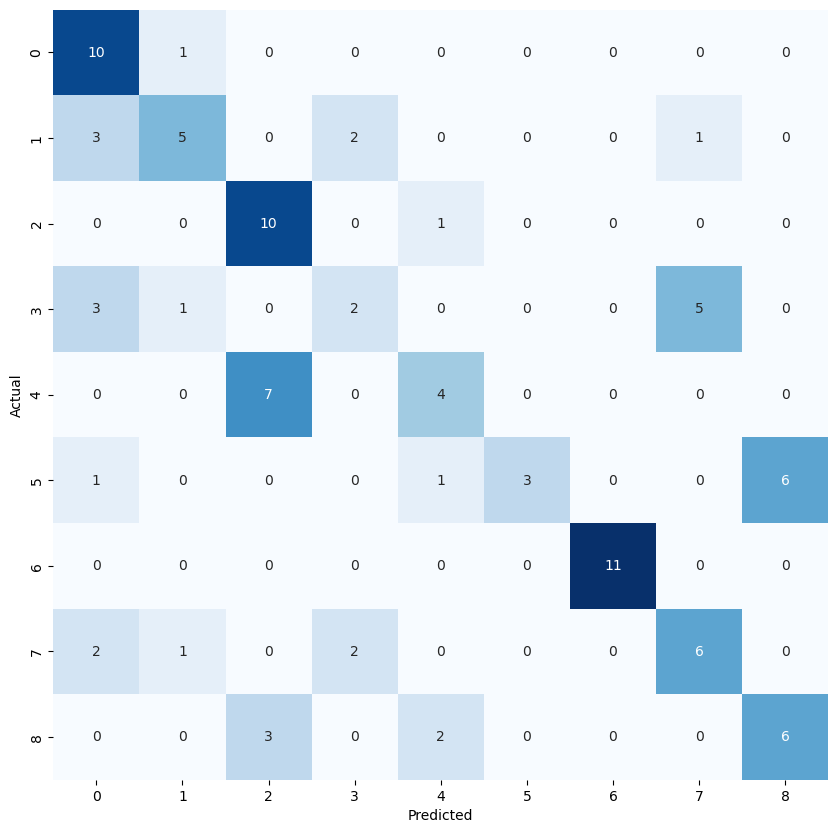

In [32]:
#make a heatmap of the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test1, y_pred1)
plt.figure(figsize=(10, 10))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted') 
plt.ylabel('Actual')
plt.show()


In [33]:
# repeat all the steps with the df_lf_hf_ia like we did witht he df_lf_hf dataframe
#drop user column as we dont need it for the svm approach and comparison
df_lf_hf_ia = df_lf_hf_ia.drop(columns=['user'])

# convert activity column to numerical values
df_lf_hf_ia['activity'] = df_lf_hf_ia['activity'].apply(convert_activity)


In [34]:
df_lf_hf_ia.head()

,activity,LFia,HFia
0,0,"[62.63175333681161, 67.14820173335953, 67.8861...","[13.105872439196567, 15.057671311078881, 14.98..."
1,0,"[117.24347583905454, 120.07741411009444, 125.0...","[49.30159777302439, 45.071411563526254, 47.155..."
2,0,"[111.54849471512217, 112.44251168329953, 112.4...","[31.36543351350337, 31.66538885079125, 33.9216..."
3,0,"[50.124183344365115, 56.5920711660148, 73.4288...","[34.533560426437795, 40.33041688226922, 57.631..."
4,0,"[20.79935035613921, 21.107786818647025, 21.080...","[13.46250778948595, 13.073058961065392, 12.520..."


In [35]:
# funtions to find the longest length of the list in the df_lf_hf_ia dataframe column LFia and HFia separately
def find_max_len_lfia(df):
    max_len = 0
    for i in range(len(df)):
        if len(df['LFia'][i]) > max_len:
            max_len = len(df['LFia'][i])
    return max_len

def find_max_len_hfia(df):
    max_len = 0
    for i in range(len(df)):
        if len(df['HFia'][i]) > max_len:
            max_len = len(df['HFia'][i])
    return max_len

# test to see if the function works
print(find_max_len_lfia(df_lf_hf_ia))
print(find_max_len_hfia(df_lf_hf_ia))


45
45


In [36]:
#funtion to make new columns from the values in the list in the df_lf_hf_ia dataframe column LFia and HFia separately so each value in the list is a new column and as these is diversity in list length we will pad the list with 0s to make all the lists of the same length
def make_new_columns_lfia(df):
    max_len = find_max_len_lfia(df)
    for i in range(max_len):
        df['LFia_' + str(i)] = 0
    return df

def make_new_columns_hfia(df):
    max_len = find_max_len_hfia(df)
    for i in range(max_len):
        df['HFia_' + str(i)] = 0
    return df

# test to see if the function works
make_new_columns_lfia(df_lf_hf_ia)
make_new_columns_hfia(df_lf_hf_ia)

#funtion to fill the new columns with the values in the list in the df_lf_hf_ia dataframe column LFia and HFia separately
def fill_new_columns_lfia(df):
    for i in range(len(df)):
        for j in range(len(df['LFia'][i])):
            df['LFia_' + str(j)][i] = df['LFia'][i][j]
    return df

def fill_new_columns_hfia(df):
    for i in range(len(df)):
        for j in range(len(df['HFia'][i])):
            df['HFia_' + str(j)][i] = df['HFia'][i][j]
    return df

# test to see if the function works
fill_new_columns_lfia(df_lf_hf_ia)
fill_new_columns_hfia(df_lf_hf_ia)

#drop the column LFia and HFia as we have made new columns from the values in the list in the df_lf_hf_ia dataframe column LFia and HFia and also drop a full nan row that was created in the process
df_lf_hf_ia = df_lf_hf_ia.drop(columns=['LFia', 'HFia'])


In [37]:
df_lf_hf_ia.head()

,activity,LFia_0,LFia_1,LFia_2,LFia_3,LFia_4,LFia_5,LFia_6,LFia_7,LFia_8,...,HFia_35,HFia_36,HFia_37,HFia_38,HFia_39,HFia_40,HFia_41,HFia_42,HFia_43,HFia_44
0,0,62.631753,67.148202,67.886119,60.225803,55.183002,52.420787,43.973574,38.986292,44.100339,...,21.863392,21.711496,21.695860,24.065517,27.510477,24.491717,21.266540,0.000000,0.000000,0.0
1,0,117.243476,120.077414,125.095778,119.360854,119.044482,119.228472,118.231819,122.814655,124.966012,...,50.362040,58.343147,50.462582,54.272680,55.801994,61.255208,57.780208,0.000000,0.000000,0.0
2,0,111.548495,112.442512,112.442512,108.056868,113.461480,121.688080,121.916229,117.743135,112.412909,...,31.233274,26.933675,25.640864,24.179094,22.330937,19.152016,17.633077,18.658642,16.620113,0.0
3,0,50.124183,56.592071,73.428882,84.522398,98.719866,97.848215,83.193866,67.964597,55.585526,...,17.052940,18.280234,26.853627,25.106317,23.400104,24.055367,22.859409,0.000000,0.000000,0.0
4,0,20.799350,21.107787,21.080384,24.212520,28.076203,24.552794,22.244501,25.291438,31.603075,...,46.806849,31.682593,21.489535,20.204714,19.205382,17.150760,14.184447,16.149537,0.000000,0.0


In [38]:
#using the second df_lf_hf_ia to train & test the svm model -

#drop nan values
df_lf_hf_ia = df_lf_hf_ia.dropna()

# Selecting only the 'LFia' and 'HFia' columns for the prediction task
X2 = df_lf_hf_ia.drop(columns=['activity']).values
y2 = df_lf_hf_ia['activity'].values

# Setting shuffle=True to shuffle the data before splitting
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=42, stratify=y2, shuffle=True)

# Scaling the data
scaler = StandardScaler()
X_train2 = scaler.fit_transform(X_train2)  # Fit and transform the scaler on the training data only
X_test2 = scaler.transform(X_test2)

# Training the SVM model
model = svm.SVC(kernel='rbf', C=100, gamma=0.1)
model.fit(X_train2, y_train2)

# Making predictions on the test set
y_pred2 = model.predict(X_test2)
# y_pred2


In [39]:
# add the activity names to numerical values and print the classification report
target_names = ['breath_total', 'rest_total', 'stroop', 'imagestroop', 'math', 'video_plus', 'video_minus', 'reaction_time', 'reading']
print(classification_report(y_test2, y_pred2, target_names=target_names))

#save this classification report as 2d assessment
report_2d = classification_report(y_test2, y_pred2, target_names=target_names, output_dict=True)
report_2d = pd.DataFrame(report_2d).transpose()
# report_2d.to_csv('report_2d.csv')

report_2d

               precision    recall  f1-score   support

 breath_total       0.71      0.91      0.80        11
   rest_total       1.00      0.64      0.78        11
       stroop       0.54      0.64      0.58        11
  imagestroop       0.60      0.55      0.57        11
         math       0.54      0.64      0.58        11
   video_plus       0.50      0.36      0.42        11
  video_minus       1.00      1.00      1.00        11
reaction_time       0.62      0.73      0.67        11
      reading       0.20      0.18      0.19        11

     accuracy                           0.63        99
    macro avg       0.63      0.63      0.62        99
 weighted avg       0.63      0.63      0.62        99



,precision,recall,f1-score,support
breath_total,0.714286,0.909091,0.800000,11.000000
rest_total,1.000000,0.636364,0.777778,11.000000
stroop,0.538462,0.636364,0.583333,11.000000
imagestroop,0.600000,0.545455,0.571429,11.000000
math,0.538462,0.636364,0.583333,11.000000
video_plus,0.500000,0.363636,0.421053,11.000000
video_minus,1.000000,1.000000,1.000000,11.000000
reaction_time,0.615385,0.727273,0.666667,11.000000
reading,0.200000,0.181818,0.190476,11.000000
accuracy,0.626263,0.626263,0.626263,0.626263


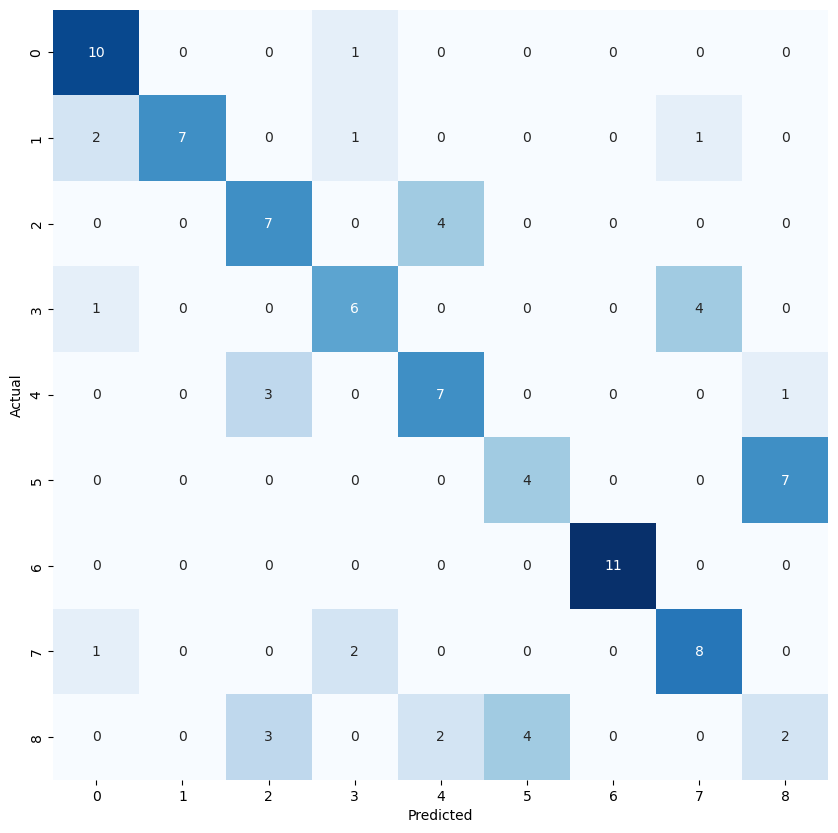

In [40]:
# plot the confusion matrix
cm2 = confusion_matrix(y_test2, y_pred2)
plt.figure(figsize=(10, 10))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted') 
plt.ylabel('Actual')
plt.show()